# DS 3000 Project: Goodreads Book Recommendation System
## Madeleine Jin, Melina Yang, Shru Kumar, Grace Pietak

In [1]:
# Imports
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
sns.set()

## Web Scraping/Functions

In [2]:
def scrape_shelf(url):
    """
    Scrapes GoodReads shelf using Beautiful Soup for book information (ex. title, author, genre) and stores in a pandas dataframe

    Arguments:
        url (str): link to list of books
    Returns:
    	df_books (pd.DataFrame): df holding books in shelf and associated info
    """
    # Gets soup from given url
    str_html = requests.get(url).text
    soup = BeautifulSoup(str_html)
    soup_class = soup.find_all(class_="js-tooltipTrigger tooltipTrigger")
    
    # Creates empty lists
    titles = []
    authors = []
    blurbs = []
    genres = []
    book_urls = []
    book_ratings = []
    num_ratings = []
    num_reviews = []

    # Adds each individual book's URL into book_urls list
    for book_soup in soup_class:

        # Extract each url and append the book's URL to the book_urls list
        a_tag = book_soup.find('a')
        book_link = a_tag['href']
        shelf_link = f'https://www.goodreads.com{book_link}'
        book_urls.append(shelf_link)

    # Iterate through each book's URL in book_urls
    for book_link in book_urls:

        # Parse the HTML content using BeautifulSoup
        str_html = requests.get(book_link).text
        soup = BeautifulSoup(str_html)
        
        # Titles
        title = soup.find_all(class_="Text Text__title1")[0].text
        titles.append(title)
        
        # Ratings
        rating = soup.find_all(class_="RatingStatistics__rating")[1].text
        book_ratings.append(float(rating))
        
        # Number of ratings
        ratings_reviews = soup.find_all(class_="RatingStatistics__meta")[1].text
        ratings_count = ratings_reviews.split()[0].replace(',','')
        num_ratings.append(int(ratings_count))

        # Number of reviews
        reviews_count = ratings_reviews.split()[1].split('s')[1].replace(',','')
        num_reviews.append(int(reviews_count))
        
        # Authors
        author = soup.find_all(class_="ContributorLink__name")[0].text
        authors.append(author)
        
        # Genres
        genre = soup.find_all('div', {'class': "BookPageMetadataSection__genres"})
        genre = genre[0]
        ul_tag = soup.find('ul', class_='CollapsableList')
        genre_spans = ul_tag.find_all('span', class_='Button__labelItem')
        new_genre = [span.text for span in genre_spans]
        new_genre = new_genre[:-1]
        genres.append(new_genre)
        
        # Blurbs
        blurb = soup.find_all(class_="Formatted")[0].text
        blurbs.append(blurb)
    
    # Put into dictionary
    books_dict = {'Titles': titles, 
                  'Authors': authors, 
                  'Genres': genres,
                  'Blurbs': blurbs,
                  'Book URLs': book_urls, 
                  'Book Ratings': book_ratings,
                  'Num Ratings': num_ratings, 
                  'Num Reviews': num_reviews}
    
    # Convert to dataframe and return it
    df = pd.DataFrame(books_dict)
    return df

In [3]:
# Call scrape_shelf function and store dataframe in 'df'
df = scrape_shelf('https://www.goodreads.com/review/list/158906936-madeleine-jin?order=a&shelf=to-read&sort=position')
df.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews
0,I Know Why the Caged Bird Sings,Maya Angelou,"[Nonfiction, Classics, Memoir, Biography, Auto...",Maya Angelou’s debut memoir is a modern Americ...,https://www.goodreads.com/book/show/13214.I_Kn...,4.29,516880,15666
1,The Catcher in the Rye,J.D. Salinger,"[Classics, Fiction, Young Adult, Literature, S...",It's Christmas time and Holden Caulfield has j...,https://www.goodreads.com/book/show/5107.The_C...,3.80,3415181,81508
2,Where the Crawdads Sing,Delia Owens,"[Fiction, Historical Fiction, Mystery, Romance...","For years, rumors of the “Marsh Girl” haunted ...",https://www.goodreads.com/book/show/36809135-w...,4.40,2765292,196467
3,All the Light We Cannot See,Anthony Doerr,"[Historical Fiction, Fiction, Historical, War,...",Marie-Laure lives in Paris near the Museum of ...,https://www.goodreads.com/book/show/18143977-a...,4.32,1542417,100518
4,Anna Karenina,Leo Tolstoy,"[Classics, Fiction, Romance, Russia, Historica...",Acclaimed by many as the world's greatest nove...,https://www.goodreads.com/book/show/15823480-a...,4.09,824471,33849


## Recommendation System

In [4]:
def recommendation_by_genre(df, genre, count=5):
    """ 
    Recommends books based on genre given by the user.

    Arguments:
       df (pd.DataFrame): DataFrame containing book information.
       genre (str): Genre the user wants to read.
       count (int): Number of recommended books. Default is 5.
       
    Returns:
        df_recommended (pd.DataFrame): DataFrame containing recommended books.
    """
    # Filter rows based on genre
    filtered_rows = []
    for index, row in df.iterrows():
        if genre in row['Genres']:
            filtered_rows.append(row)

    # Create DataFrame 'df_recommended' with filtered rows
    df_recommended = pd.DataFrame(filtered_rows, columns=df.columns)

    # Sort by 'Num Reviews' and 'Num Ratings'
    df_recommended = df_recommended.sort_values(by=['Num Reviews', 'Num Ratings'], ascending=False)
    df_recommended = df_recommended.reset_index(drop=True)

    # Finished DataFrame with recommended books
    return df_recommended.head(count)

In [5]:
df_recommended_genre = recommendation_by_genre(df=df, genre='Memoir', count=5)
df_recommended_genre.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews
0,Spare,Prince Harry,"[Nonfiction, Memoir, Audiobook, Biography, Aut...",It was one of the most searing images of the t...,https://www.goodreads.com/book/show/62296528-s...,3.88,299807,34909
1,I Know Why the Caged Bird Sings,Maya Angelou,"[Nonfiction, Classics, Memoir, Biography, Auto...",Maya Angelou’s debut memoir is a modern Americ...,https://www.goodreads.com/book/show/13214.I_Kn...,4.29,516880,15666
2,"Why Fish Don't Exist: A Story of Loss, Love, a...",Lulu Miller,"[Nonfiction, Science, Memoir, History, Biograp...",A wondrous debut from an extraordinary new voi...,https://www.goodreads.com/book/show/50887097-w...,4.17,34834,5463


In [6]:
def recommendation_by_keyword(df, keyword, count=1):
    """
    Recommends books that have the specified keyword within their reviews.
    
    Arguments:
        df (pd.DataFrame): DataFrame containing book information.
        keyword (str): Keyword the user wants to read about.
        count (int): Number of recommended books (default is 1).
    Returns:
        df_recommended (pd.DataFrame): DataFrame containing recommended books and associated information.
    """
    # Filter rows based on keyword
    filtered_rows = []
    for index, row in df.iterrows():
        if keyword.lower() in row['Blurbs']:
            filtered_rows.append(row)

    # Create DataFrame 'df_recommended' with filtered rows
    df_recommended = pd.DataFrame(filtered_rows, columns=df.columns)
    df_recommended = df_recommended.reset_index(drop=True)

    return df_recommended.head(count)

In [36]:
df_recommended_keyword = recommendation_by_keyword(df=df, keyword='funny', count=1)
df_recommended_keyword.head()

C:\Users\shrut\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews,sim_scores,KMeans
0,"Really Good, Actually",Monica Heisey,"[Fiction, Contemporary, Audiobook, Romance, Hu...",A hilarious and painfully relatable debut nove...,https://www.goodreads.com/book/show/60877616-r...,10.21839,0.055561,0.120334,1.525526,0


In [8]:
def get_sim_scores(df, title):
    """
    Calculate similarity scores based on genres and blurbs.

    Parameters:
        df (pandas DataFrame): DataFrame containing books.
        title (string): Book title to calculate similarity scores.

    Returns:
        df (pandas DataFrame): Updated DataFrame with added 'sim_scores' column.
    """
    # Genres formatted for count vector
    df['str_genres'] = [','.join(map(str, l)) for l in df['Genres']]
    
    # Count vectorizer for genres
    count = CountVectorizer(stop_words='english')
    count_matrix = count.fit_transform(df['str_genres'])
    
    # Returning df back to original
    df.drop(columns = ['str_genres'], inplace = True)
    
    # TF-IDF Vectorizer removes stop words and fits and transforms the data
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['Blurbs'])
        
    # Maps indexes
    df = df.reset_index(drop=True)
    indices = pd.Series(df.index, index=df['Titles'])
    idx = indices[title]

    # Compute the cosine similarity matrix using linear kernel and sort books based on scores
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    genre_sim_scores = list(enumerate(cosine_sim[idx]))

    # Compute the cosine similarity matrix using linear kernel and sort books based on scores
    cosine_sim2 = linear_kernel(tfidf_matrix, tfidf_matrix)    
    blurb_sim_scores = list(enumerate(cosine_sim2[idx]))    
    
    # Simalarity scores for genre and blurb
    sim_scores = []
    for i in range(len(genre_sim_scores)):
        sim_scores.append(genre_sim_scores[i][1] + blurb_sim_scores[i][1])
    df['sim_scores'] = sim_scores

    # Finished DataFrame with recommended books
    return df

In [9]:
df_sim_score = get_sim_scores(df=df, title='Spare')
df_sim_score.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews,sim_scores
0,I Know Why the Caged Bird Sings,Maya Angelou,"[Nonfiction, Classics, Memoir, Biography, Auto...",Maya Angelou’s debut memoir is a modern Americ...,https://www.goodreads.com/book/show/13214.I_Kn...,4.29,516880,15666,0.700443
1,The Catcher in the Rye,J.D. Salinger,"[Classics, Fiction, Young Adult, Literature, S...",It's Christmas time and Holden Caulfield has j...,https://www.goodreads.com/book/show/5107.The_C...,3.80,3415181,81508,0.121977
2,Where the Crawdads Sing,Delia Owens,"[Fiction, Historical Fiction, Mystery, Romance...","For years, rumors of the “Marsh Girl” haunted ...",https://www.goodreads.com/book/show/36809135-w...,4.40,2765292,196467,0.209760
3,All the Light We Cannot See,Anthony Doerr,"[Historical Fiction, Fiction, Historical, War,...",Marie-Laure lives in Paris near the Museum of ...,https://www.goodreads.com/book/show/18143977-a...,4.32,1542417,100518,0.172337
4,Anna Karenina,Leo Tolstoy,"[Classics, Fiction, Romance, Russia, Historica...",Acclaimed by many as the world's greatest nove...,https://www.goodreads.com/book/show/15823480-a...,4.09,824471,33849,0.021015


In [28]:
def recommendation_by_book(df, title, n_clusters):
    """
    Generate list of book recommendations using similarity scores and k-means clustering.

    Parameters:
        df (pd.DataFrame): DataFrame containing book information.
        title (str): Book title for recommendations.
        n_clusters (int): Number of clusters used in k-means clustering.

    Returns:
        df_recommended (pd.DataFrame): DataFrame of recommended books.
        silhouette_avg (float): Silhouette score for the clustering.
        df (pd.DataFrame): DataFrame containing book information.
    """
    # Define the features used in scaling and clustering and calculate similarity scores
    x_feat_list = ['Book Ratings', 'Num Ratings', 'Num Reviews', 'sim_scores']
    df = get_sim_scores(df, title)

    # Extract and scale features for k-means clustering
    for feat in x_feat_list:
        df[feat] = df[feat] / df[feat].std()
    x = df.loc[:, x_feat_list].values

    # E k-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    y = kmeans.predict(x)

    # Assign cluster labels
    df['KMeans'] = y
    
    # Get the index of the given inputted book
    book_idx = np.where(df["Titles"] == title)
    
    # Find books in the same cluster
    sim_books_idx = [idx for idx, cluster_label in enumerate(df['KMeans']) if cluster_label == int(df.loc[book_idx, 'KMeans'])]
    sim_books_idx.remove(book_idx[0])
    
    # Extract and clean the DataFrame of recommended books
    df_recommended = df.iloc[sim_books_idx]
    df_recommended = df_recommended.drop(columns=['KMeans'])

    # Calculate silhouette score
    silhouette_avg = silhouette_score(x, y)

    # Finished DataFrame with recommended books and clustering score
    return df_recommended, silhouette_avg, df

In [29]:
def evaluate_n_clusters(df, title, start_clusters=2, end_clusters=(len(df)-1), num_iterations=20):
    """
    Runs the silhouette_avg score for a range of n_clusters values.

    Parameters:
        df (pd.DataFrame): DataFrame containing book information.
        title (str): Book title for recommendations.
        start_clusters (int): Starting value for n_clusters. Default is 2.
        end_clusters (int): Ending value for n_clusters. Default is (len(df)-1).
        num_iterations (int): Number of iterations to run the evaluation. Default is 20.

    Returns:
        mean_silhouette_scores (list): List of silhouette_avg scores for each n_clusters value.
        best_n_clusters (int): best number of n_clusters for k-means
    """
    # Loops through and recalculates silhouette_avg score num_iterations number of times
    silhouette_scores_all_iterations = []
    for _ in range(num_iterations):
        
        # Initialize a list 'scores_ls' to store the silhouette_avg score from each execution of get_recommendations
        scores_ls = []

        # Suppress FutureWarnings
        warnings.simplefilter(action='ignore', category=FutureWarning)

        # Run get_recommendations function on a variety of n_clusters values and store score in scores_ls
        for i in range(start_clusters, end_clusters):
            df_recommended_clustering, score, df= recommendation_by_book(df=df, title=title, n_clusters=i)
            scores_ls.append(score)

        # Reset warnings to default after the loop
        warnings.resetwarnings()

        # Append silhouette scores for this iteration to the list
        silhouette_scores_all_iterations.append(scores_ls)

    # Calculate the mean silhouette score for each n_clusters value across all iterations
    mean_silhouette_scores = np.mean(silhouette_scores_all_iterations, axis=0)

    # Find the n_clusters value with the highest mean silhouette score
    best_n_clusters = start_clusters + np.argmax(mean_silhouette_scores)

    # Line plot for mean silhouette_avg score
    plt.plot(mean_silhouette_scores)
    plt.title('n_clusters vs. mean silhouette_avg score')
    plt.xlabel('n_clusters')
    plt.ylabel('mean silhouette_avg score')
    plt.show()

    return mean_silhouette_scores, best_n_clusters

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

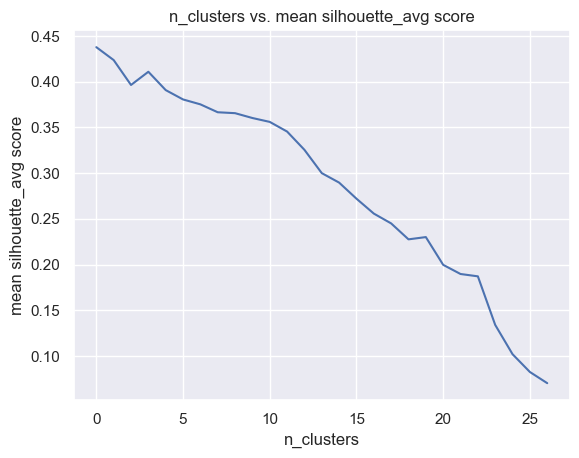

Best n_clusters value: 2


In [30]:
mean_silhouette_scores, best_n_clusters = evaluate_n_clusters(df=df, title='Paper Towns', start_clusters=2, end_clusters=(len(df)-1), num_iterations=20)
print("Best n_clusters value:", best_n_clusters)

In [31]:
# Call get_recommendations function and suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df_recommended_clustering, score, df = recommendation_by_book(df=df, title='Paper Towns', n_clusters=best_n_clusters)
warnings.resetwarnings()
df_recommended_clustering.head()

C:\Users\shrut\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews,sim_scores
1,The Catcher in the Rye,J.D. Salinger,"[Classics, Fiction, Young Adult, Literature, S...",It's Christmas time and Holden Caulfield has j...,https://www.goodreads.com/book/show/5107.The_C...,12.249175,3.741335,1.427060,1.681090
2,Where the Crawdads Sing,Delia Owens,"[Fiction, Historical Fiction, Mystery, Romance...","For years, rumors of the “Marsh Girl” haunted ...",https://www.goodreads.com/book/show/36809135-w...,14.183255,3.029380,3.439788,2.315639
3,All the Light We Cannot See,Anthony Doerr,"[Historical Fiction, Fiction, Historical, War,...",Marie-Laure lives in Paris near the Museum of ...,https://www.goodreads.com/book/show/18143977-a...,13.925377,1.689720,1.759891,1.065267
5,The Seven Husbands of Evelyn Hugo,Taylor Jenkins Reid,"[Fiction, Romance, Historical Fiction, LGBT, C...",Aging and reclusive Hollywood movie icon Evely...,https://www.goodreads.com/book/show/32620332-t...,14.279959,2.865904,4.282424,1.604640
9,People We Meet on Vacation,Emily Henry,"[Romance, Fiction, Contemporary, Contemporary ...",Two best friends. Ten summer trips. One last c...,https://www.goodreads.com/book/show/54985743-p...,12.539287,1.119858,1.727099,1.606155


In [35]:
fig = px.scatter(df, x = 'Book Ratings', y = 'Num Ratings', color = 'KMeans', title = 'K-Means Clusters', color_continuous_scale='Bluered_r')
fig.update_traces(marker_size=10)
fig.show()

C:\Users\shrut\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

C:\Users\shrut\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

